In [1]:

from template_match import read_image_rgb, read_image_gray, process_template, template_match, \
    detect_points, find_tolerance_limit, simplify_points

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import cv2 as cv

In [3]:
from ipywidgets import interact, widgets

In [4]:
def draw_image(image: np.ndarray) -> None:
    plt.imshow(cv.cvtColor(image, cv.COLOR_BGR2RGB))



def draw_points_on_canvas(points: np.ndarray, image: np.ndarray) -> None:
    x = points[:, 0]
    y = points[:, 1]
    
    clear_canvas = image.copy()
    clear_canvas[:, :] = 255
    plt.scatter(x, y, alpha=0.5, s=5)
    plt.imshow(cv.cvtColor(clear_canvas, cv.COLOR_BGR2RGB))

In [5]:
import os
import pathlib
from typing import List, Tuple
import numpy as np
import cv2 as cv
from sklearn.cluster import AgglomerativeClustering
from dotenv import load_dotenv
from setup_logger import logger


BASE_DIR = pathlib.Path(__name__).resolve().parent.parent
load_dotenv(BASE_DIR / '.env')
DATA_PATH = pathlib.Path(os.getenv("DATA_PATH"))

In [34]:
PLOT_NUMBER = 6
MARKER_NUMBER = 2

PLOT_PATH = DATA_PATH / f"plot{PLOT_NUMBER}.png"
# TEMPLATE_PATH = DATA_PATH / f"plot{PLOT_NUMBER}_marker{MARKER_NUMBER}.png"
TEMPLATE_PATH = DATA_PATH / "markers_orig" / f"plot{PLOT_NUMBER}_marker{MARKER_NUMBER}.png"

## Step-by-step pipeline

### 1) Draw image and marker

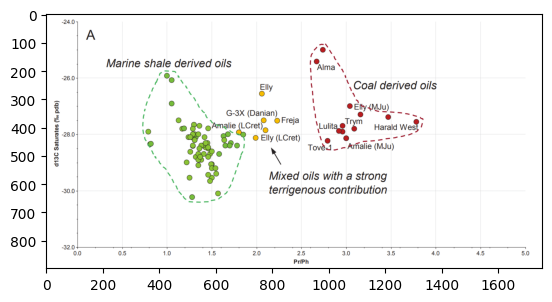

In [35]:
source_image = read_image_rgb(PLOT_PATH)
draw_image(source_image)

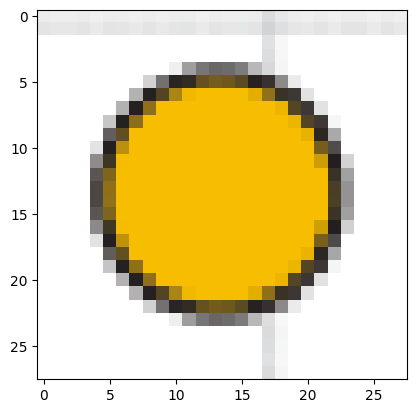

In [36]:
template_rgb = read_image_rgb(TEMPLATE_PATH)
w, h = template_rgb.shape[1], template_rgb.shape[0]

draw_image(template_rgb)

### 2) Template treshholding

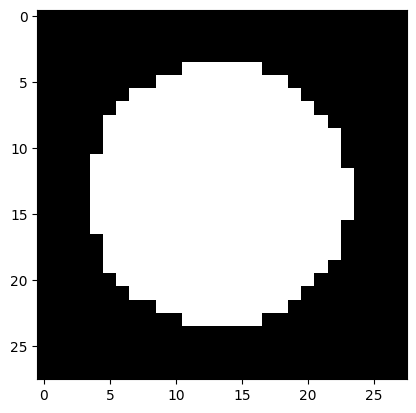

In [37]:
mask = process_template(template_rgb, treshold=200)
draw_image(mask)

### 3) Template match, get convolution map

In [38]:
# methods = ['cv.TM_CCOEFF', 'cv.TM_CCOEFF_NORMED', 'cv.TM_CCORR',
#            'cv.TM_CCORR_NORMED', 'cv.TM_SQDIFF', 'cv.TM_SQDIFF_NORMED']
# method = 'cv.TM_CCORR_NORMED'
method = 'cv.TM_SQDIFF_NORMED'


convolution_map, max_val = template_match(source_image, template_rgb, mask, method_name=method)

DEBUG - template_match.py - template_match: Convolution map was inverted


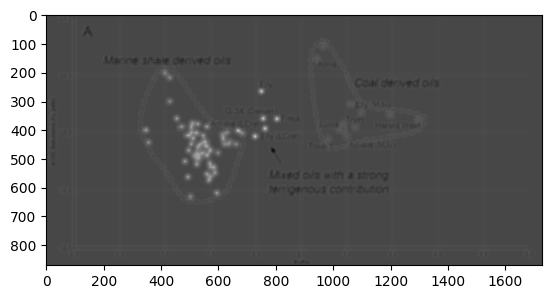

In [39]:
plt.imshow(convolution_map, cmap="gray")

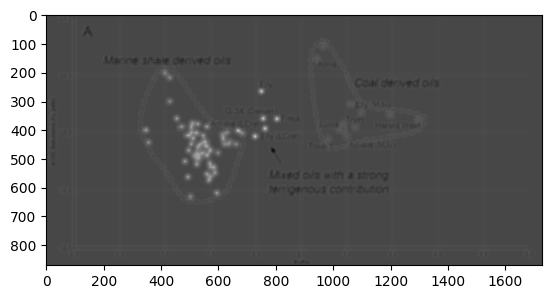

In [40]:
plt.imshow(convolution_map, cmap="gray")

### Detect points example

In [41]:
points = detect_points(convolution_map, max_val, tolerance=0.05)
x = points[:, 0]
y = points[:, 1]

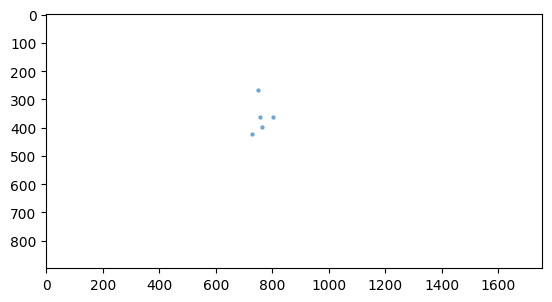

In [42]:
draw_points_on_canvas(points, source_image)

### 4) Find detection tolerance limit

In [43]:
tolerance_limit = find_tolerance_limit(convolution_map)
tolerance_limit

0.34

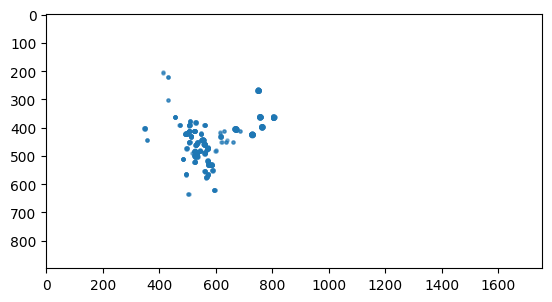

In [44]:
# run detection with limit tolerance value
points = detect_points(convolution_map, max_val, tolerance=tolerance_limit)
draw_points_on_canvas(points, source_image)

### Clustering example

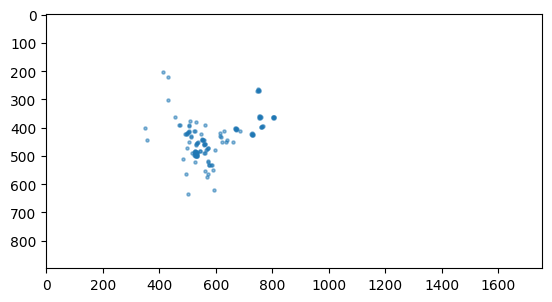

In [45]:
eps = 5

actual_points = simplify_points(points, eps)
draw_points_on_canvas(actual_points, source_image)

### 5) Select best tolerance and eps


Need gloabal variables `convolution_map`, `max_val`, `w`, `h`

In [48]:
@interact(tolerance=widgets.FloatSlider(value=0.01, min=0.01, max=tolerance_limit, step=0.01),
          eps=widgets.FloatSlider(value=1.5, min=1.5, max=15, step=0.5))
def visualize(tolerance, eps):

    points = detect_points(convolution_map, max_val, tolerance=tolerance)

    actual_points = simplify_points(points, eps)
    x = actual_points[:, 0]
    y = actual_points[:, 1]

    ## founded points on original image
    plt.figure(figsize=(10, 6))
    draw_image(source_image)
    x += w / 2
    y += h / 2
    plt.scatter(x, y, s=5, c="red", marker="*")
    plt.xticks([]); plt.yticks([]);
    plt.show()
    
    ## founded points on clear canvas
    plt.figure(figsize=(10, 6))
    draw_points_on_canvas(actual_points, source_image)

interactive(children=(FloatSlider(value=0.01, description='tolerance', max=0.34, min=0.01, step=0.01), FloatSl…